# <center> Network Analysis

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import powerlaw

In [10]:
!pip install powerlaw

In [11]:
import pickle
import pandas as pd

In [12]:
import scipy.stats as stats

In [13]:
import warnings
warnings.filterwarnings('ignore')

## Učitavanje prečišćenih podataka za kreiranje mreže

In [14]:
with open("data_cleaned", 'rb') as file:
    data = pickle.load(file)

In [15]:
list_source_id = set(data['source_subreddit'].unique())
list_target_id = set(data['target_subreddit'].unique())

set_id = list_source_id.union(list_target_id)
print(f"Postoji { len(set_id) } različitih subredita") 

Postoji 3565 različitih subredita


## Kreiranje SNet mreze

In [16]:
G = nx.from_pandas_edgelist(data, 'source_subreddit', 'target_subreddit',
                            create_using=nx.DiGraph(), edge_attr='weight')

In [17]:
output_path = "models/SNet.gml"

nx.write_gml(G, output_path)

#### Odredjivanje broja grana i cvorova SNet mreze

In [18]:
num_of_nodes = G.number_of_nodes()
num_of_edges = G.number_of_edges()

In [19]:
print(f'Broj cvorova u SNet mrezi je {num_of_nodes}.')
print(f'Broj grana u SNet mrezi je {num_of_edges}.')

Broj cvorova u SNet mrezi je 3565.
Broj grana u SNet mrezi je 313918.


### Odredjivanje gustine SNet mreze

In [20]:
print(f'Gustina SNet mreze je {round(nx.density(G), 5)}.')

Gustina SNet mreze je 0.02471.


#### Prosečne distance u okviru mreže i dijametar mreže

GEPHI:
eigenvector centrality:  0.2075172146835821

In [21]:
nx.number_weakly_connected_components(G)

20

In [22]:
components_size_list = [len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]

In [23]:
largest_component = G.subgraph(max(nx.weakly_connected_components(G), key=len))

In [24]:
output_path = "models/G_largest_component.gml"

nx.write_gml(largest_component, output_path)

In [25]:
largest_component.number_of_edges()

313868

### Analiza centralnosti mreze

##### Centralnost bazirana na stepenu cvora

In [26]:
DC_dict = nx.degree_centrality(G)
DC_sorted_dict = dict(sorted(DC_dict.items(), key=lambda x: x[1], reverse=True))
df1 = pd.DataFrame.from_dict(DC_sorted_dict, orient='index', columns=['DC'])

print(df1.head(10))

                     DC
reddit.com     1.763749
technology     1.246352
politics       1.240741
pics           1.218294
funny          1.191358
science        1.181257
worldnews      1.173401
entertainment  1.156566
WTF            1.147026
programming    1.146465


##### Centralnost po bliskosti

In [27]:
CC_dict = nx.closeness_centrality(G)
CC_sorted_dict = dict(sorted(CC_dict.items(), key=lambda x: x[1], reverse=True))
df2 = pd.DataFrame.from_dict(CC_sorted_dict, orient='index', columns=['CC'])

print(df2.head(10))

                     CC
reddit.com     0.891570
technology     0.719965
politics       0.717739
pics           0.711871
funny          0.704383
science        0.701970
worldnews      0.700276
entertainment  0.695938
WTF            0.693305
programming    0.692753


##### Relaciona centralnost

In [ ]:
BC_dict = nx.betweenness_centrality(G)
BC_sorted_dict = dict(sorted(BC_dict.items(), key=lambda x: x[1], reverse=True))
df3 = pd.DataFrame.from_dict(BC_sorted_dict, orient='index', columns=['BC'])
print(df3.head(10))

##### Centralnost po sopstvenom vektoru

In [ ]:
EVC_dict = nx.eigenvector_centrality(G)
EVC_sorted_dict = dict(sorted(EVC_dict.items(), key=lambda x: x[1], reverse=True))
df4 = pd.DataFrame.from_dict(EVC_sorted_dict, orient='index', columns=['EVC'])
print(df4.head(10))

Veca vrednost ove centralnosti ukazuje na vecu povezanost posmatranog cvora sa drugim uticajnim cvorovima (koji imaju veci broj suseda).

##### Uporedjivanje dobijenih centralnosti

In [ ]:
df = pd.concat([df1, df2, df3, df4], axis=1)
print(df.head())

##### Matrica korelacije dobijenih centralnosti

In [ ]:
labels = ['DC', 'CC', 'BC', 'EVC']
cross_correlation_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])
p_val_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])

In [ ]:
for ind in labels:
    for col in labels:
        cross_correlation_matrix[ind][col], _ =  stats.kendalltau(df[ind], df[col])

In [ ]:
cross_correlation_matrix

$\tau_b(x,y) = \frac{(P - Q)}{\sqrt((P + Q + T)}\times(P + Q + U))$ gde je P broj podudarnih parova, Q je broj nepodudarnih parova, T je broj veza samo u x, dok je U broj veza samo u y.

Na osnovu matrice korelacija vidimo da su mere centralnosti pozitivno korelisane, što je očekivano i važi za većinu socijalnih mreža. Najslabija je korelacija između EV centralnosti i relacione centralnosti.

##### Vizuelizacija centralnosti

In [ ]:
def plot_rank_correlation(ax, x_rank, y_rank, x_label, y_label):                                                      

    ax.set_xlabel(x_label)                                                                                                            
    ax.set_xscale('linear')                                                                                                                
    ax.set_xlim(1, max(x_rank))  

    ax.set_ylabel(y_label)                                                                                                          
    ax.set_yscale('linear')                                                                                                                
    ax.set_ylim(1, max(y_rank))                                                                                                             
                                                                                                                                                                                                    
    ax.scatter(x_rank, y_rank, marker='.')                                                                                                    

In [ ]:
df_ = df[['BC', 'EVC']]
df_['BC_rank'] = df['BC'].rank(ascending=False) 
df_['EVC_rank'] = df['EVC'].rank(ascending=False) 
df_p = df_.sort_values(['BC_rank'], ascending=True)

In [ ]:
df__ = df[['CC', 'EVC']]
df__['CC_rank'] = df['CC'].rank(ascending=False) 
df__['EVC_rank'] = df['EVC'].rank(ascending=False) 
df__p = df__.sort_values(['CC_rank'], ascending=True)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))
plot_rank_correlation(ax[0], df_['BC_rank'], df_['EVC_rank'], 'BC', 'EVC')
plot_rank_correlation(ax[1], df__['CC_rank'], df__['EVC_rank'], 'CC', 'EVC')
plt.suptitle('Prikaz najmanje i najvece korelacije medju centralnostima', fontsize=14)
plt.show()

##### Izvlacenje bitnih cvorova (Kompozitni rank)

In [ ]:
df_rank = df
for metric in labels:
    df_rank[f"{metric}_rank"] = df[f"{metric}"].rank(ascending=False) 
    
df_rank['composite_rank'] = df_rank['DC_rank'] * df_rank['CC_rank'] * df_rank['BC_rank'] * df_rank['EVC_rank']

df_rank.sort_values(['composite_rank'], ascending = True, inplace=True)
df_rank.head(10)

#### Distribucija cvorova po stepenu

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

max_deg = max(deg) 

values, base = np.histogram(deg, bins = max_deg)

cumulative = np.cumsum(values)

plt.plot(base[:-1], [float(x)/len(data) for x in len(data) - cumulative], c='blue')
plt.title('Prikaz distribucije cvorova po stepenu', fontsize=18)
plt.xlabel('') 

plt.show()

In [ ]:
results = powerlaw.Fit(degree_sequence)

In [ ]:
print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.sigma)
R, p = results.distribution_compare('truncated_power_law', 'exponential')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('exponential', 'power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")

# Modelovanje SNetF mreze

In [15]:
snetF = nx.DiGraph()
snetF.add_nodes_from(set_id)

NameError: name 'set_id' is not defined

### Raspodela tezina grana u mrezi

In [14]:
plt.hist(list(data['weight']), density=False, bins=50)  # density=False would make counts
plt.ylabel('broj grana')
plt.xlabel('tezina')
#plt.xlim(0,0.2)
plt.title('Raspodela grana po tezinama', fontsize=18)
plt.show()

NameError: name 'data' is not defined

In [25]:
print('Minimalna tezina grane u SNet mrezi je: ' + str(min(data['weight'])))
print('Maksimana tezina grane u SNet mrezi je: ' + str(max(data['weight'])))
print('Srednja vrednost tezina grane u SNet mrezi je: ' + str(np.mean(data['weight'])))
print('Medijana tezina grana u SNet mrezi je: ' + str(np.median(data['weight'])))

Minimalna tezina grane u SNet mrezi je: 3.66010336090166e-10
Maksimana tezina grane u SNet mrezi je: 0.9922779922779923
Srednja vrednost tezina grane u SNet mrezi je: 0.008892517336749107
Medijana tezina grana u SNet mrezi je: 9.122422915526363e-05


### Filtriranje grana na osnovu tezine

In [26]:
weight_sequence = list(data['weight'])

weight_sequence = sorted(weight_sequence, key=None, reverse=True) # opadajuca lista
index_01 = int(len(weight_sequence)*0.01)   # izdvajamo 1 posto grana sa najvecim tezinama
weight_01 = weight_sequence[0:index_01]

In [27]:
weight_threshhold = weight_01[-1]  # min tezina koju treba da predje grana da bi usla u graf
print(f'Minimalna tezina koju treba da predje grana da bi usla u graf je {round(weight_threshhold,4)}.')
for _, source_id, target_id, weight in data.itertuples():
    if (weight > weight_threshhold):
        snetF.add_edge(source_id, target_id, weight = weight)

Minimalna tezina koju treba da predje grana da bi usla u graf je 0.1955.


In [28]:
output_path = "models/SNetF.gml"

nx.write_gml(snetF, output_path)

In [29]:
print(f'SNetF mreza ima {snetF.number_of_edges()} grana.')
print(f'SNetF mreza ima {snetF.number_of_nodes()} cvorova.')

SNetF mreza ima 3138 grana.
SNetF mreza ima 3565 cvorova.


### Analiza centralnosti mreze

##### Centralnost na osnovu stepena cvora

In [146]:
DC_dict = nx.degree_centrality(snetF)
DC_sorted_dict = dict(sorted(DC_dict.items(), key=lambda x: x[1], reverse=True))
df1 = pd.DataFrame.from_dict(DC_sorted_dict, orient='index', columns=['DC'])

##### Centralnost po bliskosti

In [147]:
CC_dict = nx.closeness_centrality(snetF)
CC_sorted_dict = dict(sorted(CC_dict.items(), key=lambda x: x[1], reverse=True))
df2 = pd.DataFrame.from_dict(CC_sorted_dict, orient='index', columns=['CC'])

##### Relaciona centralnost

In [148]:
BC_dict = nx.betweenness_centrality(snetF)
BC_sorted_dict = dict(sorted(BC_dict.items(), key=lambda x: x[1], reverse=True))
df3 = pd.DataFrame.from_dict(BC_sorted_dict, orient='index', columns=['BC'])

##### Centralnost po sopstvenom vektoru

In [149]:
EVC_dict = nx.eigenvector_centrality(snetF)
EVC_sorted_dict = dict(sorted(EVC_dict.items(), key=lambda x: x[1], reverse=True))
df4 = pd.DataFrame.from_dict(EVC_sorted_dict, orient='index', columns=['EVC'])

##### Uporedjivanje dobijenih centralnosti

In [150]:
labels = ['DC', 'CC', 'BC', 'EVC']
cross_correlation_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])

In [151]:
df = pd.concat([df1, df2, df3, df4], axis=1)
for ind in labels:
    for col in labels:
        cross_correlation_matrix[ind][col], _ =  stats.kendalltau(df[ind], df[col])

In [80]:
cross_correlation_matrix

DC        CC        BC       EVC
DC        1.0   0.37462  0.195853  0.372094
CC    0.37462       1.0  0.401568  0.982272
BC   0.195853  0.401568       1.0  0.389135
EVC  0.372094  0.982272  0.389135       1.0

##### Vizuelizacija metrika korelacije

In [81]:
df_ = df[['BC', 'DC']]
df_['BC_rank'] = df['BC'].rank(ascending=False) 
df_['DC_rank'] = df['DC'].rank(ascending=False) 
df_p = df_.sort_values(['BC_rank'], ascending=True)

df__ = df[['CC', 'EVC']]
df__['CC_rank'] = df['CC'].rank(ascending=False) 
df__['EVC_rank'] = df['EVC'].rank(ascending=False) 
df__p = df__.sort_values(['CC_rank'], ascending=True)

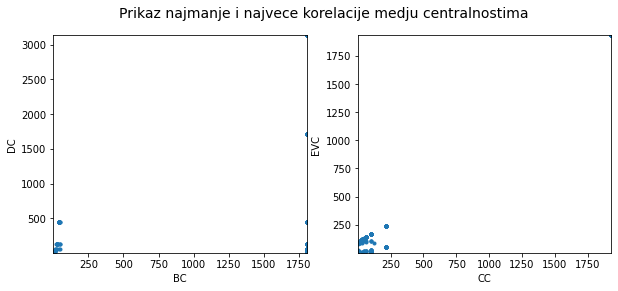

In [82]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))
plot_rank_correlation(ax[0], df_['BC_rank'], df_['DC_rank'], 'BC', 'DC')
plot_rank_correlation(ax[1], df__['CC_rank'], df__['EVC_rank'], 'CC', 'EVC')
plt.suptitle('Prikaz najmanje i najvece korelacije medju centralnostima', fontsize=14)
plt.show()

##### Katzova centralnost

In [152]:
centrality_1 = nx.katz_centrality(snetF)

In [153]:
centrality_1 = list(sorted(centrality_1.items(), key=lambda x: x[1], reverse=True))
df_cent = pd.DataFrame.from_records(centrality_1, columns =['node', 'katz_1'])
print(df_cent.head())

          node    katz_1
0   reddit.com  0.902837
1     politics  0.196673
2  programming  0.128171
3         pics  0.044996
4     business  0.038800


In [160]:
beta = {} 
for key in set_id:
    beta[key] = 1
beta['reddit.com'] = 500

In [161]:
centrality_500 = nx.katz_centrality(snetF, beta=beta)
centrality_500 = list(sorted(centrality_500.items(), key=lambda x: x[1], reverse=True))
df_cent_500 = pd.DataFrame.from_records(centrality_500, columns =['node', 'katz_500'])
print(df_cent_500.head())

          node  katz_500
0   reddit.com  0.993433
1     politics  0.052333
2  programming  0.034105
3         pics  0.011973
4     business  0.010324


In [87]:
beta['reddit.com'] = 0.0005
centrality_05 = nx.katz_centrality(snetF, beta=beta)
centrality_05 = list(sorted(centrality_05.items(), key=lambda x: x[1], reverse=True))
df_cent_05 = pd.DataFrame.from_records(centrality_05, columns =['node', 'katz_05'])
print(df_cent_05.head())

          node   katz_05
0   reddit.com  0.901780
1     politics  0.197684
2  programming  0.128830
3         pics  0.045227
4     business  0.039000


In [144]:
df_katz = pd.concat([df_cent,df_cent_500['katz_500'], df_cent_05['katz_05']], axis=1)
print(df_katz.head())

          node    katz_1  katz_500   katz_05
0   reddit.com  0.902837  0.993433  0.901780
1     politics  0.196673  0.052333  0.197684
2  programming  0.128171  0.034105  0.128830
3         pics  0.044996  0.011973  0.045227
4     business  0.038800  0.010324  0.039000


Povecanjem parametra $\beta$ povecava se Katzova centralnost za cvor reddit.com, dok se vrednosti ove centralnosti za ostale cvorove smanjuju. 
Za parametar $\beta=0$ dobijaju se ekvivalentni rezultati kao za slucaj EVC.
Za dovoljno veliko $\beta$ Katzova centralnost posmatranog cvora je 1, dok za ostale iznosi priblizno 0.

##### Kompozitni rank

In [154]:
df.head()

DC        CC        BC           EVC
reddit.com   0.421717  0.443236  0.000000  9.382359e-04
politics     0.094276  0.094168  0.000015  4.466968e-05
programming  0.060045  0.060215  0.000000  1.784302e-07
pics         0.019641  0.019360  0.000003  8.912283e-05
technology   0.016554  0.016274  0.000002  1.356444e-08

In [159]:
df_cent = df_cent.set_index('node')
df_cent.index.name = None
df = df.join(df_cent['katz_1'],how='left')

labels = ['DC', 'CC', 'BC', 'EVC', 'katz_1']
for metric in labels:
    df_rank[f"{metric}_rank"] = df[f"{metric}"].rank(ascending=False) 
    
df_rank['composite_rank'] = df_rank['DC_rank'] * df_rank['CC_rank'] * df_rank['BC_rank'] * df_rank['EVC_rank'] * df_rank['katz_1_rank']
df_rank = df_rank[['DC_rank', 'CC_rank', 'BC_rank', 'EVC_rank', 'composite_rank']]
df_rank.sort_values(['composite_rank'], ascending = True, inplace=True)
df_rank.head(10)

DC_rank  CC_rank  BC_rank  EVC_rank  composite_rank
politics           2.0      2.0      1.0      28.0          224.00
pics               4.0      4.0      2.0      18.0         2304.00
entertainment      7.0      7.0      3.0      17.0        17493.00
reddit.com         1.0      1.0   1808.5      10.0        18085.00
business           5.5      5.0      4.0      84.0        46200.00
technology         5.5      6.0      5.0      88.0        87120.00
worldnews          8.0      8.0      6.0      90.0       276480.00
science           11.0     11.0      7.0      93.0       866481.00
WTF               12.5     12.5      8.0      92.0      1380000.00
funny             12.5     12.5      9.0      95.0      1736718.75

# Modelovanje SnetT mreze

#### Ucitavanje ulaznih podataka

In [45]:
posts = pd.DataFrame()
curr = pd.DataFrame()
for i in range(12):
    filename = f'submissions_2008_asm/csv-{i}.csv'
    curr = pd.read_csv(filename)
    posts = pd.concat([curr, posts])

#### Izdvajanje podataka za SNetT mrezu

In [46]:
target_subreddits = {'reddit.com', 'pics', 'worldnews', 'programming', 'business', 'politics', 'obama', 'science',
                    'technology', 'WTF', 'AskReddit', 'netsec', 'philosophy', 'videos', 'offbeat', 'funny', 
                    'entertainment', 'linux', 'geek', 'gaming', 'comics', 'gadgets', 'nsfw', 'news', 'environment',
                    'atheism', 'canada', 'math', 'Economics', 'scifi', 'bestof', 'cogsci', 'joel', 'Health', 'guns',
                    'photography', 'software', 'history', 'ideas'}

In [47]:
snetT = G.subgraph(target_subreddits)

In [194]:
snetT.number_of_edges()

1482

In [48]:
data_filter = (data['source_subreddit'].isin(target_subreddits)) & (data['target_subreddit'].isin(target_subreddits))
snetT_data = data.loc[data_filter]

[ 1  1 12 20 24 27 28 30 32 34 35 36 37 37 37 37 37 37 37 37 37 37 37 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 39]


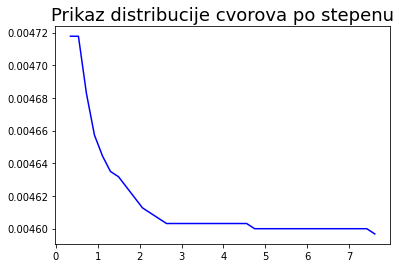

In [187]:
degree_sequence = sorted([d for n, d in snetT.degree(weight='weight')], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

max_deg = max(deg) 

values, base = np.histogram(deg, bins = len(deg))

cumulative = np.cumsum(values)
print(cumulative)

plt.plot(base[:-1], [float(x)/len(data) for x in len(snetT_data) - cumulative], c='blue')
plt.title('Prikaz distribucije cvorova po stepenu', fontsize=18)
plt.xlabel('') 

plt.show()

In [49]:
print(f'U SNetT mrezu uslo je {snetT.number_of_nodes()} cvorova.')

U SNetT mrezu uslo je 39 cvorova.


In [50]:
print(f'Dimenzije dobijenog skupa podatka za SNet mrezu su: {snetT_data.shape}.')

Dimenzije dobijenog skupa podatka za SNet mrezu su: (1482, 3).


#### Odredjivanje grana koje ulaze u SNetT mrezu

In [51]:
weight_sequence = list(snetT_data['weight'])

weight_sequence = sorted(weight_sequence, key=None, reverse=True) # opadajuca lista
index_10 = int(len(weight_sequence)*0.1)   # izdvajamo 20 posto grana sa najvecim tezinama
index_60 = int(len(weight_sequence)*0.6)  
weight_10 = weight_sequence[0:index_10]

In [52]:
weight_threshhold = weight_10[-1]  # min tezina koju treba da predje grana da bi usla u graf
print(f'Minimalna tezina koju treba da predje grana da bi usla u graf je {round(weight_threshhold,4)}.')
for _, source_id, target_id, weight in snetT_data.itertuples():
    if (weight > weight_threshhold):
        snetT.add_edge(source_id, target_id, weight = weight)

Minimalna tezina koju treba da predje grana da bi usla u graf je 0.0454.


NetworkXError: Frozen graph can't be modified

#### Smestanje grafa u .gml fajl

In [53]:
output_path = "models/SNetT.gml"

nx.write_gml(snetT, output_path)

#### Provera komponenti SNetT mreze

In [54]:
components_size_list = [len(c) for c in sorted(nx.weakly_connected_components(snetT), key=len, reverse=True)]
largest_component = snetT.subgraph(max(nx.weakly_connected_components(snetT), key=len))
#print(nx.diameter(largest_component))#.diameter()
print(largest_component.number_of_edges())
print(nx.average_shortest_path_length(largest_component))

1482
1.0


In [55]:
output_path = "models/SNetT_largest_component.gml"

nx.write_gml(largest_component, output_path)

### Analiza centralnosti mreze

##### Centralnost na osnovu stepena cvora

In [56]:
DC_dict = nx.degree_centrality(snetT)
DC_sorted_dict = dict(sorted(DC_dict.items(), key=lambda x: x[1], reverse=True))
df1 = pd.DataFrame.from_dict(DC_sorted_dict, orient='index', columns=['DC'])
print(df1.head())

              DC
gaming       2.0
technology   2.0
obama        2.0
environment  2.0
comics       2.0


##### Centralnost po bliskosti

In [57]:
CC_dict = nx.closeness_centrality(snetT)
CC_sorted_dict = dict(sorted(CC_dict.items(), key=lambda x: x[1], reverse=True))
df2 = pd.DataFrame.from_dict(CC_sorted_dict, orient='index', columns=['CC'])
print(df2.head())

              CC
gaming       1.0
technology   1.0
obama        1.0
environment  1.0
comics       1.0


##### Relaciona centralnost

In [58]:
BC_dict = nx.betweenness_centrality(snetT)
BC_sorted_dict = dict(sorted(BC_dict.items(), key=lambda x: x[1], reverse=True))
df3 = pd.DataFrame.from_dict(BC_sorted_dict, orient='index', columns=['BC'])
print(df3.head())

              BC
gaming       0.0
technology   0.0
obama        0.0
environment  0.0
comics       0.0


##### Centralnost po sopstvenom vektoru

In [59]:
EVC_dict = nx.eigenvector_centrality(snetT)
EVC_sorted_dict = dict(sorted(EVC_dict.items(), key=lambda x: x[1], reverse=True))
df4 = pd.DataFrame.from_dict(EVC_sorted_dict, orient='index', columns=['EVC'])
print(df4.head())

                  EVC
gaming       0.160128
technology   0.160128
obama        0.160128
environment  0.160128
comics       0.160128


##### Uporedjivanje dobijenih centralnosti

In [60]:
labels = ['DC', 'CC', 'BC', 'EVC']
cross_correlation_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])

df = pd.concat([df1, df2, df3, df4], axis=1)
print(df.head())
for ind in labels:
    for col in labels:
        cross_correlation_matrix[ind][col], _ =  stats.kendalltau(df[ind], df[col])

              DC   CC   BC       EVC
gaming       2.0  1.0  0.0  0.160128
technology   2.0  1.0  0.0  0.160128
obama        2.0  1.0  0.0  0.160128
environment  2.0  1.0  0.0  0.160128
comics       2.0  1.0  0.0  0.160128


In [61]:
cross_correlation_matrix

DC   CC   BC  EVC
DC   NaN  NaN  NaN  NaN
CC   NaN  NaN  NaN  NaN
BC   NaN  NaN  NaN  NaN
EVC  NaN  NaN  NaN  NaN

##### Vizuelizacija metrika korelacije

In [69]:
df_ = df[['BC', 'DC']]
df_['BC_rank'] = df['BC'].rank(ascending=False) 
df_['DC_rank'] = df['DC'].rank(ascending=False) 
df_p = df_.sort_values(['BC_rank'], ascending=True)
print(df_p.tail(10))

df__ = df[['CC', 'EVC']]
df__['CC_rank'] = df['CC'].rank(ascending=False) 
df__['EVC_rank'] = df['EVC'].rank(ascending=False) 
df__p = df__.sort_values(['CC_rank'], ascending=True)
print(df__p.tail(10))

              BC   DC  BC_rank  DC_rank
philosophy   0.0  2.0     20.0     20.0
science      0.0  2.0     20.0     20.0
bestof       0.0  2.0     20.0     20.0
pics         0.0  2.0     20.0     20.0
reddit.com   0.0  2.0     20.0     20.0
cogsci       0.0  2.0     20.0     20.0
photography  0.0  2.0     20.0     20.0
gadgets      0.0  2.0     20.0     20.0
worldnews    0.0  2.0     20.0     20.0
ideas        0.0  2.0     20.0     20.0
              CC       EVC  CC_rank  EVC_rank
philosophy   1.0  0.160128     20.0      20.0
science      1.0  0.160128     20.0      20.0
bestof       1.0  0.160128     20.0      20.0
pics         1.0  0.160128     20.0      20.0
reddit.com   1.0  0.160128     20.0      20.0
cogsci       1.0  0.160128     20.0      20.0
photography  1.0  0.160128     20.0      20.0
gadgets      1.0  0.160128     20.0      20.0
worldnews    1.0  0.160128     20.0      20.0
ideas        1.0  0.160128     20.0      20.0


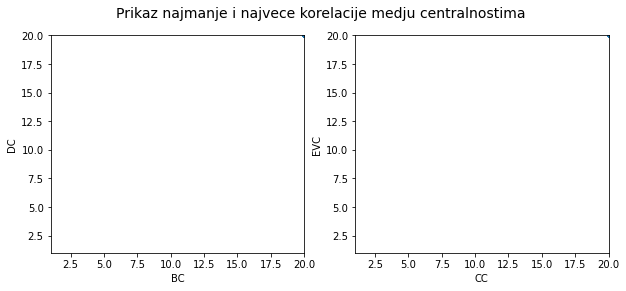

In [63]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))
plot_rank_correlation(ax[0], df_['BC_rank'], df_['DC_rank'], 'BC', 'DC')
plot_rank_correlation(ax[1], df__['CC_rank'], df__['EVC_rank'], 'CC', 'EVC')
plt.suptitle('Prikaz najmanje i najvece korelacije medju centralnostima', fontsize=14)
plt.show()

##### Katzova centralnost

In [ ]:
fejluje konvergenciju na 1000 iter

In [64]:
centrality_1 = nx.katz_centrality(snetT, max_iter=10000)

centrality_1 = list(sorted(centrality_1.items(), key=lambda x: x[1], reverse=True))
df_cent = pd.DataFrame.from_records(centrality_1, columns =['node', 'katz_1'])
print(df_cent.head())

KeyboardInterrupt: 

In [70]:
beta = {} 
for key in target_subreddits:
    beta[key] = 1
beta['reddit.com'] = 500

In [71]:
centrality_500 = nx.katz_centrality(snetT, beta=beta, max_iter=10000)
centrality_500 = list(sorted(centrality_500.items(), key=lambda x: x[1], reverse=True))
df_cent_500 = pd.DataFrame.from_records(centrality_500, columns =['node', 'katz_500'])
print(df_cent_500.head())

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 10000 iterations')

In [ ]:
beta['reddit.com'] = 0.0005
centrality_05 = nx.katz_centrality(snetT, beta=beta)
centrality_05 = list(sorted(centrality_05.items(), key=lambda x: x[1], reverse=True))
df_cent_05 = pd.DataFrame.from_records(centrality_05, columns =['node', 'katz_05'])
print(df_cent_05.head())

In [ ]:
df = pd.concat([df_cent,df_cent_500['katz_500'], df_cent_05['katz_05']], axis=1)
print(df.head())